In [1]:
import os
import sys
sys.path.append('third_party/')
sys.path.append('third_party/StableCascade/')

import yaml
import torch
from tqdm import tqdm
from accelerate.utils import set_module_tensor_to_device
import torch.nn.functional as F
import torchvision.transforms as T
transform = T.ToPILImage()
from lang_sam import LangSAM

from inference.utils import *
from core.utils import load_or_fail
from train import WurstCoreC, WurstCoreB
from gdf_rbm import RBM
from stage_c_rbm import StageCRBM
from utils import WurstCoreCRBM

from gdf.schedulers import CosineSchedule
from gdf import VPScaler, CosineTNoiseCond, DDPMSampler, P2LossWeight, AdaptiveLossWeight
from gdf.targets import EpsilonTarget

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.9). Upgrade using: pip install --upgrade albumentations


cuda:0


## Model and config setup.

### Load Config

In [2]:
# Stage C model config.
config_file = 'third_party/StableCascade/configs/inference/stage_c_3b.yaml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)

core = WurstCoreCRBM(config_dict=loaded_config, device=device, training=False)

# Stage B model config.
config_file_b = 'third_party/StableCascade/configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
core_b = WurstCoreB(config_dict=config_file_b, device=device, training=False)

['model_version', 'effnet_checkpoint_path', 'previewer_checkpoint_path']
['model_version', 'stage_a_checkpoint_path', 'effnet_checkpoint_path']


### Load Extras & Models

In [3]:
extras = core.setup_extras_pre()

gdf_rbm = RBM(
    schedule=CosineSchedule(clamp_range=[0.0001, 0.9999]),
    input_scaler=VPScaler(), target=EpsilonTarget(),
    noise_cond=CosineTNoiseCond(),
    loss_weight=AdaptiveLossWeight(),
)
sampling_configs = {"cfg": 5, "sampler": DDPMSampler(gdf_rbm), "shift": 1, "timesteps": 20}

extras = core.Extras(
            gdf=gdf_rbm,
            sampling_configs=sampling_configs,
            transforms=extras.transforms,
            effnet_preprocess=extras.effnet_preprocess,
            clip_preprocess=extras.clip_preprocess
        )

models = core.setup_models(extras)
models.generator.eval().requires_grad_(False)

extras_b = core_b.setup_extras_pre()
models_b = core_b.setup_models(extras_b, skip_clip=True)
models_b = WurstCoreB.Models(
   **{**models_b.to_dict(), 'tokenizer': models.tokenizer, 'text_model': models.text_model}
)
models_b.generator.bfloat16().eval().requires_grad_(False)

['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['tokenizer', 'text_model', 'generator', 'effnet', 'previewer']
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']
['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']
['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']


StageB(
  (effnet_mapper): Sequential(
    (0): Conv2d(16, 1280, kernel_size=(1, 1), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(1280, 320, kernel_size=(1, 1), stride=(1, 1))
    (3): LayerNorm2d((320,), eps=1e-06, elementwise_affine=False)
  )
  (pixels_mapper): Sequential(
    (0): Conv2d(3, 1280, kernel_size=(1, 1), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(1280, 320, kernel_size=(1, 1), stride=(1, 1))
    (3): LayerNorm2d((320,), eps=1e-06, elementwise_affine=False)
  )
  (clip_mapper): Linear(in_features=1280, out_features=5120, bias=True)
  (clip_norm): LayerNorm((1280,), eps=1e-06, elementwise_affine=False)
  (embedding): Sequential(
    (0): PixelUnshuffle(downscale_factor=2)
    (1): Conv2d(16, 320, kernel_size=(1, 1), stride=(1, 1))
    (2): LayerNorm2d((320,), eps=1e-06, elementwise_affine=False)
  )
  (down_blocks): ModuleList(
    (0): ModuleList(
      (0): ResBlock(
        (depthwise): Conv2d(320, 320, kernel_size=(3, 3), stri

### Plug in RB-mudulation

In [4]:
generator_rbm = StageCRBM()
for param_name, param in load_or_fail(core.config.generator_checkpoint_path).items():
    set_module_tensor_to_device(generator_rbm, param_name, "cpu", value=param)
generator_rbm = generator_rbm.to(getattr(torch, core.config.dtype)).to(device)
generator_rbm = core.load_model(generator_rbm, 'generator')

models_rbm = core.Models(
        effnet=models.effnet, previewer=models.previewer,
        generator=generator_rbm, generator_ema=models.generator_ema,
        tokenizer=models.tokenizer, text_model=models.text_model, image_model=models.image_model
    )
models_rbm.generator.eval().requires_grad_(False)


['tokenizer', 'text_model', 'generator', 'effnet', 'previewer']


StageCRBM(
  (clip_txt_mapper): Linear(in_features=1280, out_features=2048, bias=True)
  (clip_txt_pooled_mapper): Linear(in_features=1280, out_features=8192, bias=True)
  (clip_img_mapper): Linear(in_features=768, out_features=8192, bias=True)
  (clip_norm): LayerNorm((2048,), eps=1e-06, elementwise_affine=False)
  (embedding): Sequential(
    (0): PixelUnshuffle(downscale_factor=1)
    (1): Conv2d(16, 2048, kernel_size=(1, 1), stride=(1, 1))
    (2): LayerNorm2d((2048,), eps=1e-06, elementwise_affine=False)
  )
  (down_blocks): ModuleList(
    (0): ModuleList(
      (0): ResBlock(
        (depthwise): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2048)
        (norm): LayerNorm2d((2048,), eps=1e-06, elementwise_affine=False)
        (channelwise): Sequential(
          (0): Linear(in_features=2048, out_features=8192, bias=True)
          (1): GELU(approximate='none')
          (2): GlobalResponseNorm()
          (3): Dropout(p=0.1, inplace=False)
      

# Stylization

In [5]:
batch_size = 1

# ref_style_file = 'data/cyberpunk.png'
# caption = "a dog" # in cyberpunk art style

# ref_style_file = 'data/glowing.png'
# caption = "a dragon" # in glowing 3D rendering style

########################################################
# Add style descriptions for better performance (Sec.6).
# More style descriptions in data/prompts.txt file
########################################################

# style_description = 'in mosaic art style'
# ref_style_file = 'data/mosaic.png'
# caption = f"a kangaroo {style_description}"

# style_description = 'in melting golden 3d rendering style'
# ref_style_file = 'data/melting_gold.png'
# caption = f"a boy sitting on a chair {style_description}"

# style_description = 'in cartoon line drawing style'
# ref_style_file = 'data/linedrawing.png'
# caption = f"a knight on a horse {style_description}"

# style_description = 'in 3d rendering style'
# ref_style_file = 'data/rendering.jpg'
# caption = f"a toy house {style_description}"

style_description = 'in vintage travel poster style'
ref_style_file = 'data/poster.png'
caption = f"a cute boy {style_description}"


### Setup configurations and extract conditions (AFA)

In [6]:
height, width = 1024, 1024
stage_c_latent_shape, stage_b_latent_shape = calculate_latent_sizes(height, width, batch_size=batch_size)

extras.sampling_configs['cfg'] = 4
extras.sampling_configs['shift'] = 2
extras.sampling_configs['timesteps'] = 20
extras.sampling_configs['t_start'] = 1.0

extras_b.sampling_configs['cfg'] = 1.1
extras_b.sampling_configs['shift'] = 1
extras_b.sampling_configs['timesteps'] = 10
extras_b.sampling_configs['t_start'] = 1.0

ref_style = resize_image(PIL.Image.open(ref_style_file).convert("RGB")).unsqueeze(0).expand(batch_size, -1, -1, -1).to(device)

batch = {'captions': [caption] * batch_size}
batch['style'] = ref_style

x0_style_forward = models_rbm.effnet(extras.effnet_preprocess(ref_style.to(device)))

conditions = core.get_conditions(batch, models_rbm, extras, is_eval=True, is_unconditional=False, eval_image_embeds=True, eval_style=True, eval_csd=False) 
unconditions = core.get_conditions(batch, models_rbm, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    
conditions_b = core_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=False)
unconditions_b = core_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=True)

/raid/lr34477/LR/SW/miniconda/envs/rbm/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### Run sampling

In [7]:
# Stage C reverse process.
sampling_c = extras.gdf.sample(
    models_rbm.generator, conditions, stage_c_latent_shape,
    unconditions, device=device,
    **extras.sampling_configs,
    x0_style_forward=x0_style_forward,
    apply_pushforward=False, tau_pushforward=8,
    num_iter=3, eta=0.1, tau=20, eval_csd=True,
    extras=extras, models=models_rbm,
    lam_style=1, lam_txt_alignment=1.0,
    use_ddim_sampler=True,
)
for (sampled_c, _, _) in tqdm(sampling_c, total=extras.sampling_configs['timesteps']):
    sampled_c = sampled_c

  0%|          | 0/20 [00:00<?, ?it/s]

CSD model loading ...
<All keys matched successfully>


/raid/lr34477/LR/SW/miniconda/envs/rbm/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/lr34477/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


100%|██████████| 20/20 [02:14<00:00,  6.72s/it]


In [8]:
# Stage B reverse process.
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):                
    conditions_b['effnet'] = sampled_c
    unconditions_b['effnet'] = torch.zeros_like(sampled_c)
    
    sampling_b = extras_b.gdf.sample(
        models_b.generator, conditions_b, stage_b_latent_shape,
        unconditions_b, device=device, **extras_b.sampling_configs,
    )
    for (sampled_b, _, _) in tqdm(sampling_b, total=extras_b.sampling_configs['timesteps']):
        sampled_b = sampled_b
    sampled = models_b.stage_a.decode(sampled_b).float()

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


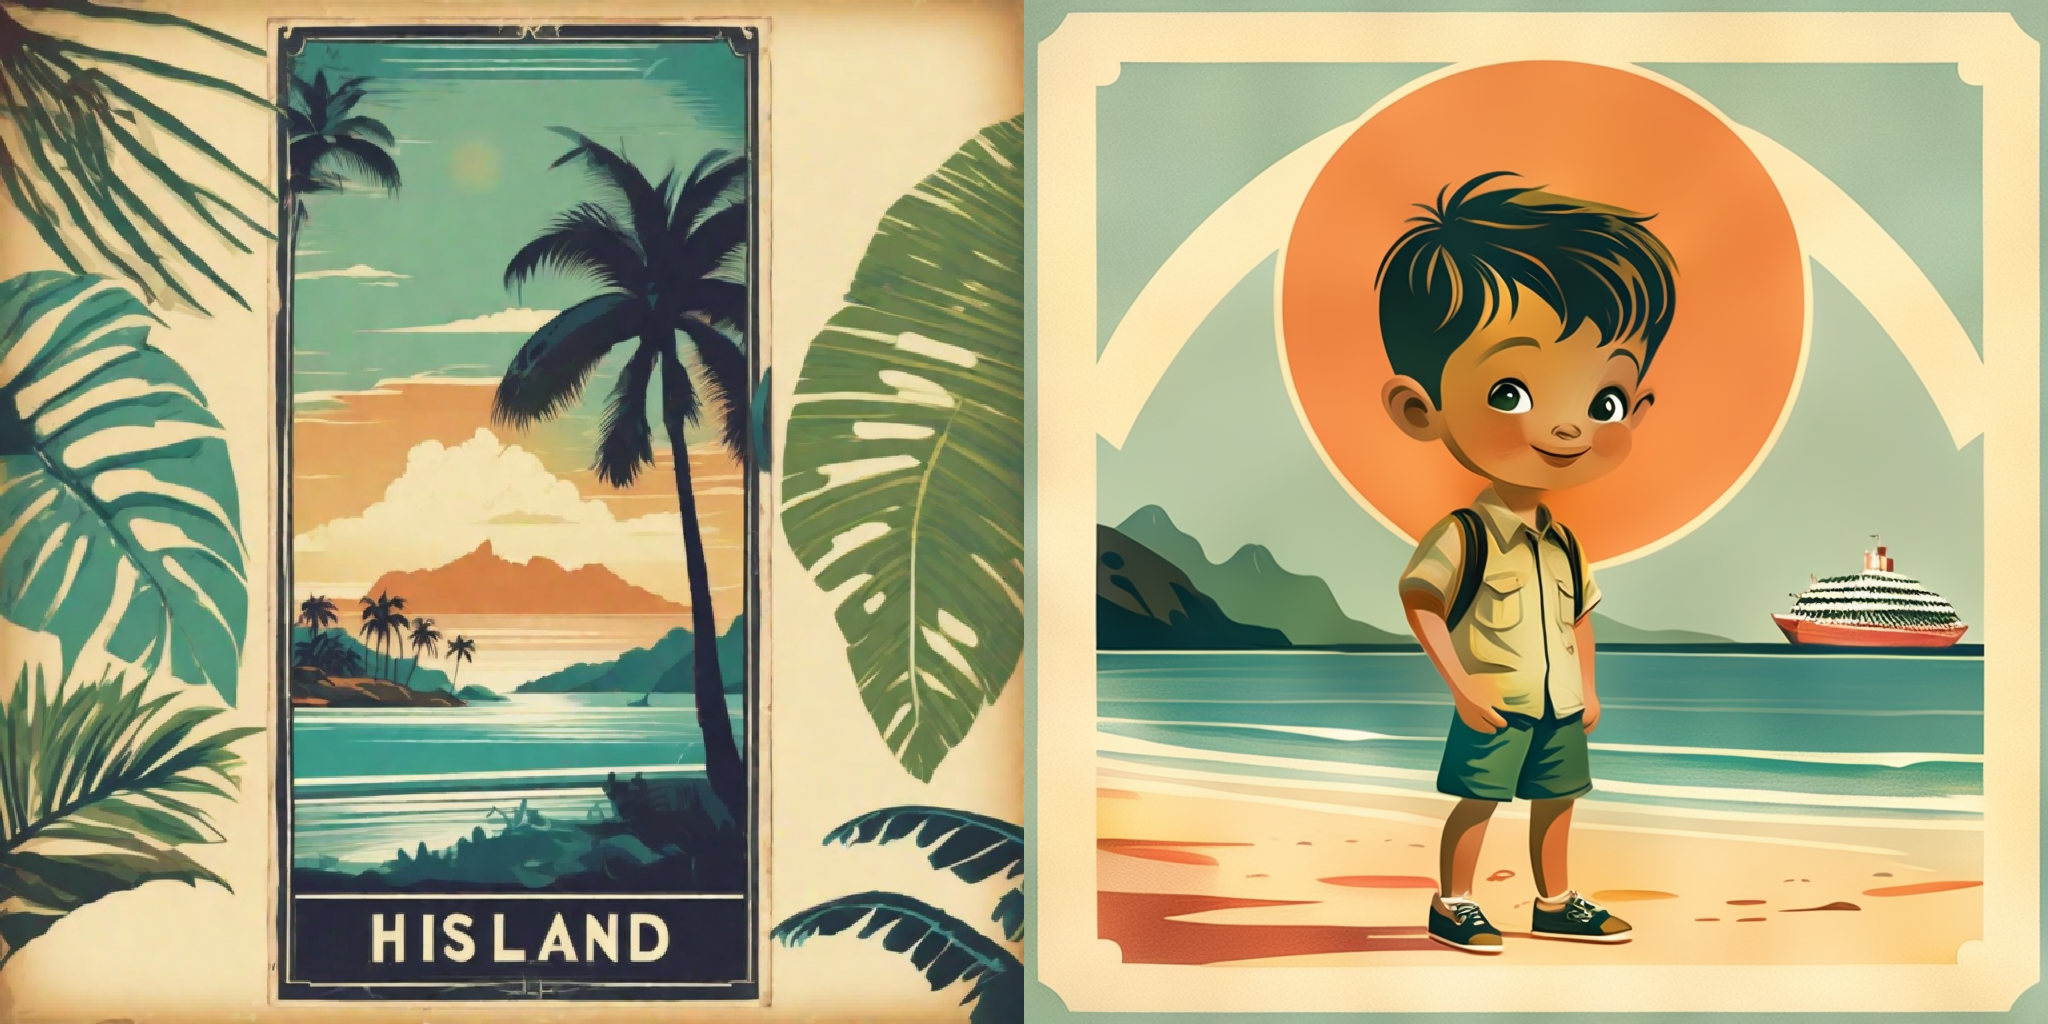

In [9]:
sampled = torch.cat([
    torch.nn.functional.interpolate(ref_style.cpu(),size=height),
    sampled.cpu(),
    ],
    dim=0)
show_images(sampled)

# Composition

In [10]:
# ref_style_file = 'data/glowing.png'
# ref_sub_file = 'data/dog.jpg'
# caption = "a dog in glowing 3D rendering style"
# sam_prompt = "a dog"
# use_sam_mask = False

ref_style_file = 'data/melting_gold.png'
ref_sub_file = 'data/cat.jpg'
caption = "a cat in melting golden 3d rendering style"
sam_prompt = "a cat"
use_sam_mask = False


### Setup configurations and extract conditions (AFA)

In [11]:
batch_size = 1
height, width = 1024, 1024
stage_c_latent_shape, stage_b_latent_shape = calculate_latent_sizes(height, width, batch_size=batch_size)

extras.sampling_configs['cfg'] = 4
extras.sampling_configs['shift'] = 2
extras.sampling_configs['timesteps'] = 20
extras.sampling_configs['t_start'] = 1.0
extras_b.sampling_configs['cfg'] = 1.1
extras_b.sampling_configs['shift'] = 1
extras_b.sampling_configs['timesteps'] = 10
extras_b.sampling_configs['t_start'] = 1.0

ref_style = resize_image(PIL.Image.open(ref_style_file).convert("RGB")).unsqueeze(0).expand(batch_size, -1, -1, -1).to(device)
ref_images = resize_image(PIL.Image.open(ref_sub_file).convert("RGB")).unsqueeze(0).expand(batch_size, -1, -1, -1).to(device)

batch = {'captions': [caption] * batch_size}
batch['style'] = ref_style
batch['images'] = ref_images

x0_forward = models_rbm.effnet(extras.effnet_preprocess(ref_images.to(device)))
x0_style_forward = models_rbm.effnet(extras.effnet_preprocess(ref_style.to(device)))

## SAM Mask for sub
use_sam_mask = False
x0_preview = models_rbm.previewer(x0_forward)
sam_model = LangSAM()
sam_mask, boxes, phrases, logits = sam_model.predict(transform(x0_preview[0]), sam_prompt)
sam_mask = sam_mask.detach().unsqueeze(dim=0).to(device)

conditions = core.get_conditions(batch, models_rbm, extras, is_eval=True, is_unconditional=False, eval_image_embeds=True, eval_subject_style=True, eval_csd=False)
unconditions = core.get_conditions(batch, models_rbm, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False, eval_subject_style=True)    
conditions_b = core_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=False)
unconditions_b = core_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=True)


final text_encoder_type: bert-base-uncased
Model loaded from /home/lr34477/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


/raid/lr34477/LR/SW/miniconda/envs/rbm/lib/python3.9/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/raid/lr34477/LR/SW/miniconda/envs/rbm/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/raid/lr34477/LR/SW/miniconda/envs/rbm/lib/python3.9/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


### Run sampling

In [12]:
# Stage C reverse process.
sampling_c = extras.gdf.sample(
    models_rbm.generator, conditions, stage_c_latent_shape,
    unconditions, device=device,
    **extras.sampling_configs,
    x0_style_forward=x0_style_forward, x0_forward=x0_forward,
    apply_pushforward=False, tau_pushforward=5, tau_pushforward_csd=10, 
    num_iter=3, eta=1e-1, tau=20, eval_sub_csd=True,
    extras=extras, models=models_rbm,  
    use_attn_mask=use_sam_mask,
    save_attn_mask=False,
    lam_content=1, lam_style=1,
    sam_mask=sam_mask, use_sam_mask=use_sam_mask,
    sam_prompt=sam_prompt
)

for (sampled_c, _, _) in tqdm(sampling_c, total=extras.sampling_configs['timesteps']):
    sampled_c = sampled_c

  0%|          | 0/20 [00:00<?, ?it/s]

CSD model loading ...
<All keys matched successfully>
final text_encoder_type: bert-base-uncased
Model loaded from /home/lr34477/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


In [13]:
# Stage B reverse process.
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):                
    conditions_b['effnet'] = sampled_c
    unconditions_b['effnet'] = torch.zeros_like(sampled_c)
    
    sampling_b = extras_b.gdf.sample(
        models_b.generator, conditions_b, stage_b_latent_shape,
        unconditions_b, device=device, **extras_b.sampling_configs,
    )
    for (sampled_b, _, _) in tqdm(sampling_b, total=extras_b.sampling_configs['timesteps']):
        sampled_b = sampled_b
    sampled = models_b.stage_a.decode(sampled_b).float()


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


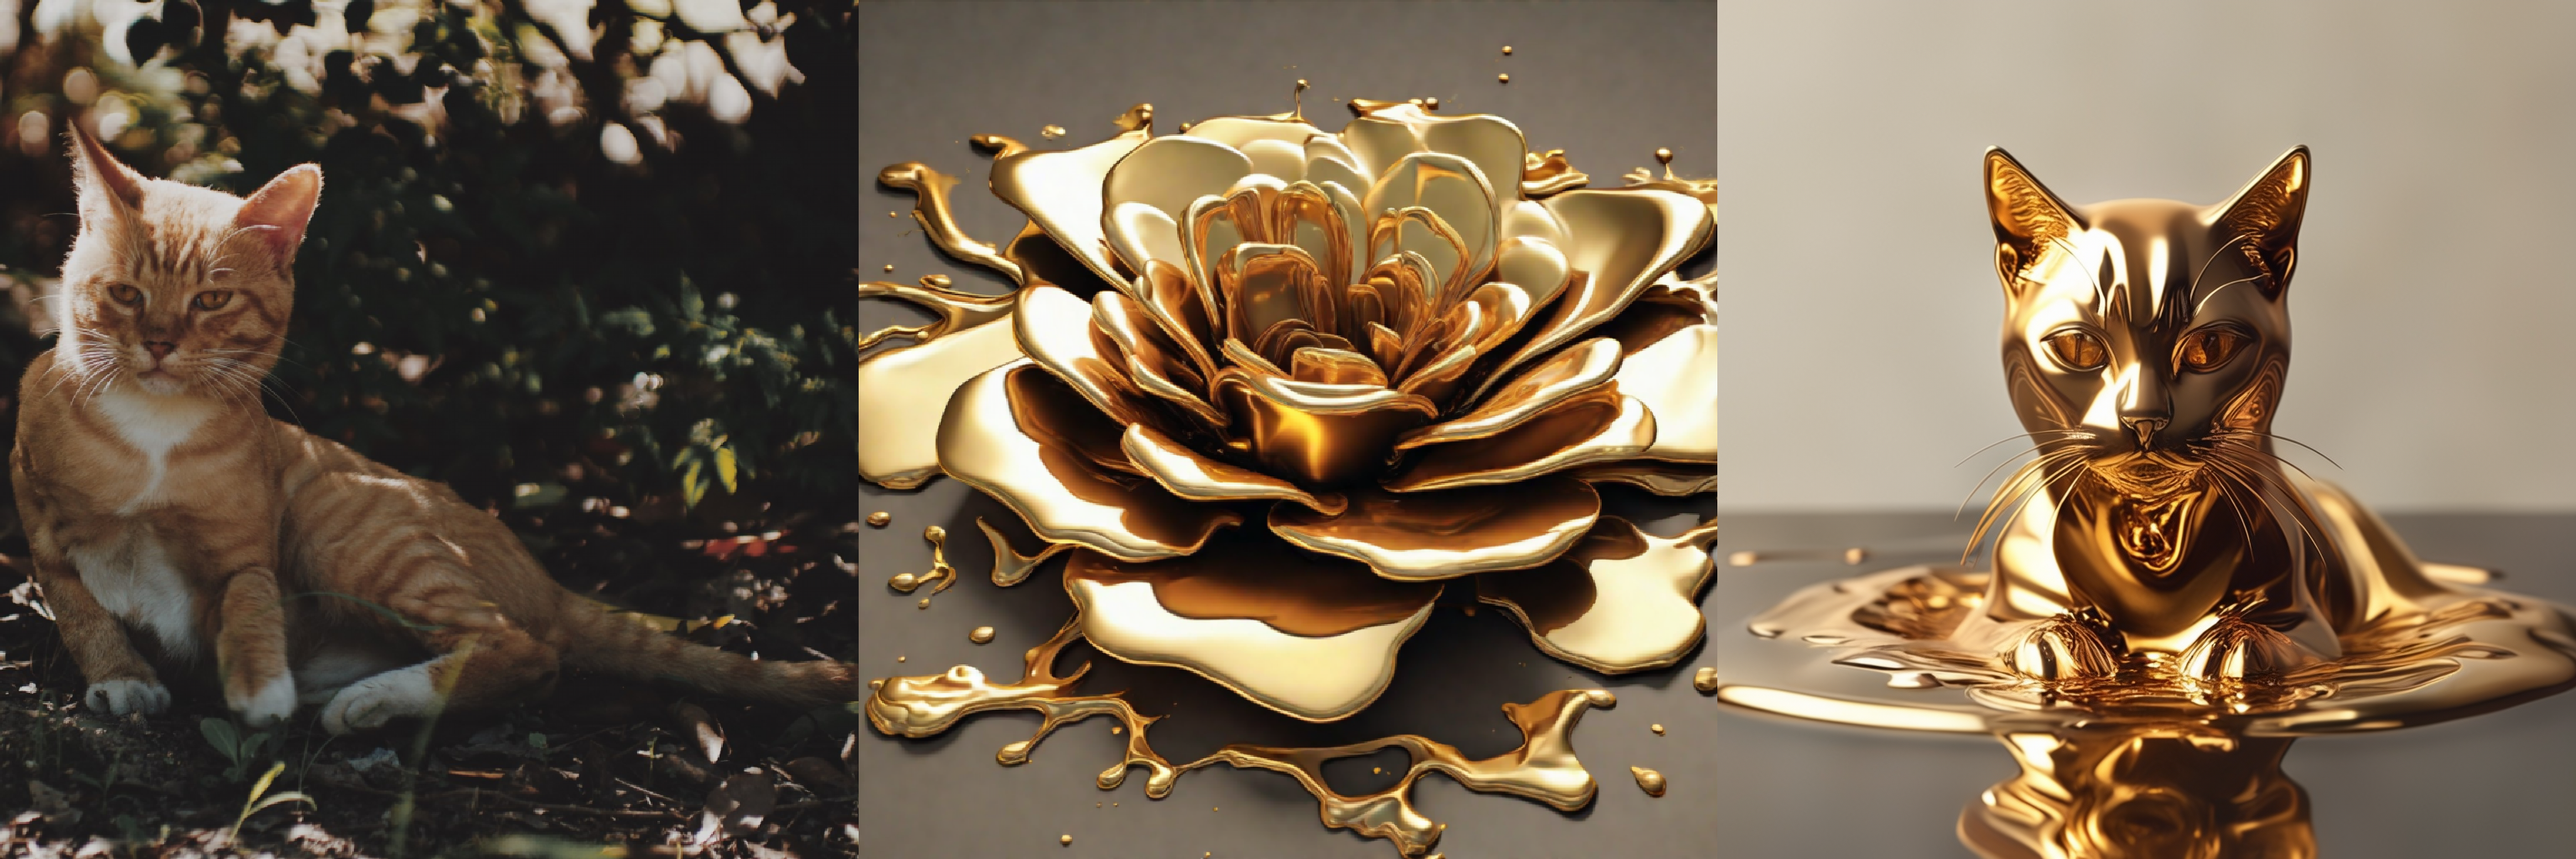

In [14]:
sampled = torch.cat([
    torch.nn.functional.interpolate(ref_images.cpu(),size=height),
    torch.nn.functional.interpolate(ref_style.cpu(),size=height),
    sampled.cpu(),
    ],
    dim=0)
show_images(sampled)